In [135]:
import numpy as np
import pandas as pd
import os
from scipy.stats import iqr
from datetime import datetime

def load_all_sis_data(folder_path):
    """
    Loads all SIS data files in a folder into a single 3D NumPy array,
    creating a dictionary to map element names to array indices.

    Args:
        folder_path (str): The path to the folder containing the SIS data files.

    Returns:
        numpy.ndarray: A 3D NumPy array (energy, time, element) representing the flux data.
              The 'element' dimension corresponds to the order in which files are loaded.
        numpy.ndarray: A 1D NumPy array of datetime objects representing the time axis.
        dict: A dictionary mapping element names to their corresponding indices in the 
              third dimension of the data array.
    """

    all_flux_data = []
    datetime_values = None
    element_mapping = {}  # Dictionary to store element-index mapping

    for i, filename in enumerate(sorted(os.listdir(folder_path))):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            element_name = filename.split("_")[0].capitalize()  # Extract element name
            element_mapping[element_name] = i  # Map element name to index

            data = np.loadtxt(filepath, skiprows=25)
            fp_year = data[:, 0]
            flux_values = data[:, 1:9]

            if datetime_values is None:
                # Use higher precision for fractional years
                datetime_values = np.array([pd.Timestamp(datetime(year=int(fp), month=1, day=1) +
                                                pd.Timedelta(days=(fp - int(fp)) * 365))
                                            for fp in fp_year])

            all_flux_data.append(flux_values)

    all_flux_data = np.stack(all_flux_data, axis=2).transpose(1, 0, 2)
    return all_flux_data, datetime_values, element_mapping

# Load all data
all_flux_data, datetime_values, element_mapping = load_all_sis_data('flux/')

print("All data shape:", all_flux_data.shape)
print("Element Mapping:", element_mapping)

All data shape: (8, 63504, 6)
Element Mapping: {'C': 0, 'Fe': 1, 'He': 2, 'N': 3, 'O': 4, 'Si': 5}


Get stats for dataset below, not used currently


In [136]:
def calculate_and_print_stats_for_elements(data_3d, element_mapping, energy_levels):
    """
    Calculates and prints statistics for specified energy levels of each element.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_levels (list): List of energy levels to calculate statistics for.
    """

    data_3d = np.where(data_3d == -999.9, np.nan, data_3d)  # Replace bad data with NaN

    for element_name, element_index in element_mapping.items():
        print(f"Statistics for {element_name}:")
        for energy_level in energy_levels:
            flux_values = data_3d[energy_level-1, :, element_index]  # Extract flux values
            valid_flux_values = flux_values[~np.isnan(flux_values)]  # Remove NaN values

            median_flux = np.median(valid_flux_values)
            std_flux = np.std(valid_flux_values)

            # Attempts at noise cutoff calculation:

            # 3 delta (STD) threshold
            #noise_cutoff = median_flux - 3 * std_flux  # Example noise cutoff

            # IQR threshold
            # Calculate IQR
            iqr_value = iqr(valid_flux_values)
            # Define noise cutoff (e.g., 1.5 times IQR below the first quartile)
            noise_cutoff = np.percentile(valid_flux_values, 25) - 1.5 * iqr_value

            print(f"  Energy Level {energy_level}:")
            print(f"    Median Flux: {median_flux:.4e}")
            print(f"    Standard Deviation: {std_flux:.4e}")
            print(f"    Noise Cutoff (Example): {noise_cutoff:.4e}")

# Example usage: Calculate stats for energy levels 1 and 2
energy_levels_to_analyze = [1, 2] 
calculate_and_print_stats_for_elements(all_flux_data, element_mapping, energy_levels_to_analyze)

Statistics for C:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 8.5523e-04
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 5.6754e-04
    Noise Cutoff (Example): 0.0000e+00
Statistics for Fe:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 9.2789e-05
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 3.8610e-05
    Noise Cutoff (Example): 0.0000e+00
Statistics for He:
  Energy Level 1:
    Median Flux: 4.5029e-05
    Standard Deviation: 3.1187e-01
    Noise Cutoff (Example): -1.1102e-04
  Energy Level 2:
    Median Flux: 2.7493e-05
    Standard Deviation: 3.1285e-01
    Noise Cutoff (Example): -1.1604e-04
Statistics for N:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 2.7527e-04
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 1.7031e-04
   

The function below identifies periods of exponential decay in a given time series of flux data.

This function uses a sliding window approach, where a fixed-size window (specified by `window_size`) is moved across the logarithmic flux data. For each position of the window, linear regression is performed on the data within the window. The regression line's slope is computed, and if this slope is less than a predefined threshold (`slope_threshold`), it indicates a significant downward trend, characteristic of an exponential decay. The start and end times of the window are recorded as a decay segment if the slope condition is met.

After identifying all potential decay segments, it proceeds to merge overlapping or adjacent segments. This step ensures that a continuous decay period is not fragmented into multiple segments. The merging process checks if the start time of a new segment is within the current segment being considered. If the segments are close enough (considering the flux increase threshold), they are merged into a single continuous segment. This merging is done iteratively to cover all identified decay periods.

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

def identify_exponential_decays(flux_data, time_data, window_size, slope_threshold):
    """
    Args:
        flux_data (numpy.ndarray): Array of flux values.
        time_data (numpy.ndarray): Array of corresponding datetime values.
        window_size (int): Size of the sliding window for linear regression (in hours).
        slope_threshold (float): Threshold for the slope to identify a decay.

    Returns:
        list: List of tuples containing start and end times of decay segments.
    """
    # Make sure flux_data contains no zero or negative values
    flux_data = np.where(flux_data > 0, flux_data, np.nan)
    log_flux_data = np.log10(flux_data)
    #log_flux_data = gaussian_filter1d(log_flux_data, sigma=1)  # Smooth the data

    decays = []
    for i in range(len(log_flux_data) - window_size):
        window = log_flux_data[i:i + window_size]
        if np.isnan(window).any():
            continue
        slope, intercept, r_value, p_value, std_err = linregress(np.arange(window_size), window)

        if slope < slope_threshold:
            start_time = time_data[i]
            end_time = time_data[i + window_size - 1]
            decays.append((start_time, end_time))
    
    # Merge overlapping or adjacent decay segments
    merged_decays = []
    for start, end in decays:
        if merged_decays and start <= merged_decays[-1][1]:
            merged_decays[-1] = (merged_decays[-1][0], max(merged_decays[-1][1], end))
        else:
            merged_decays.append((start, end))
    
    return merged_decays


Code below finds and graphs events specific to each element, but since we want to use He as a reference for other elements it is not used at the moment

8.8071e-06


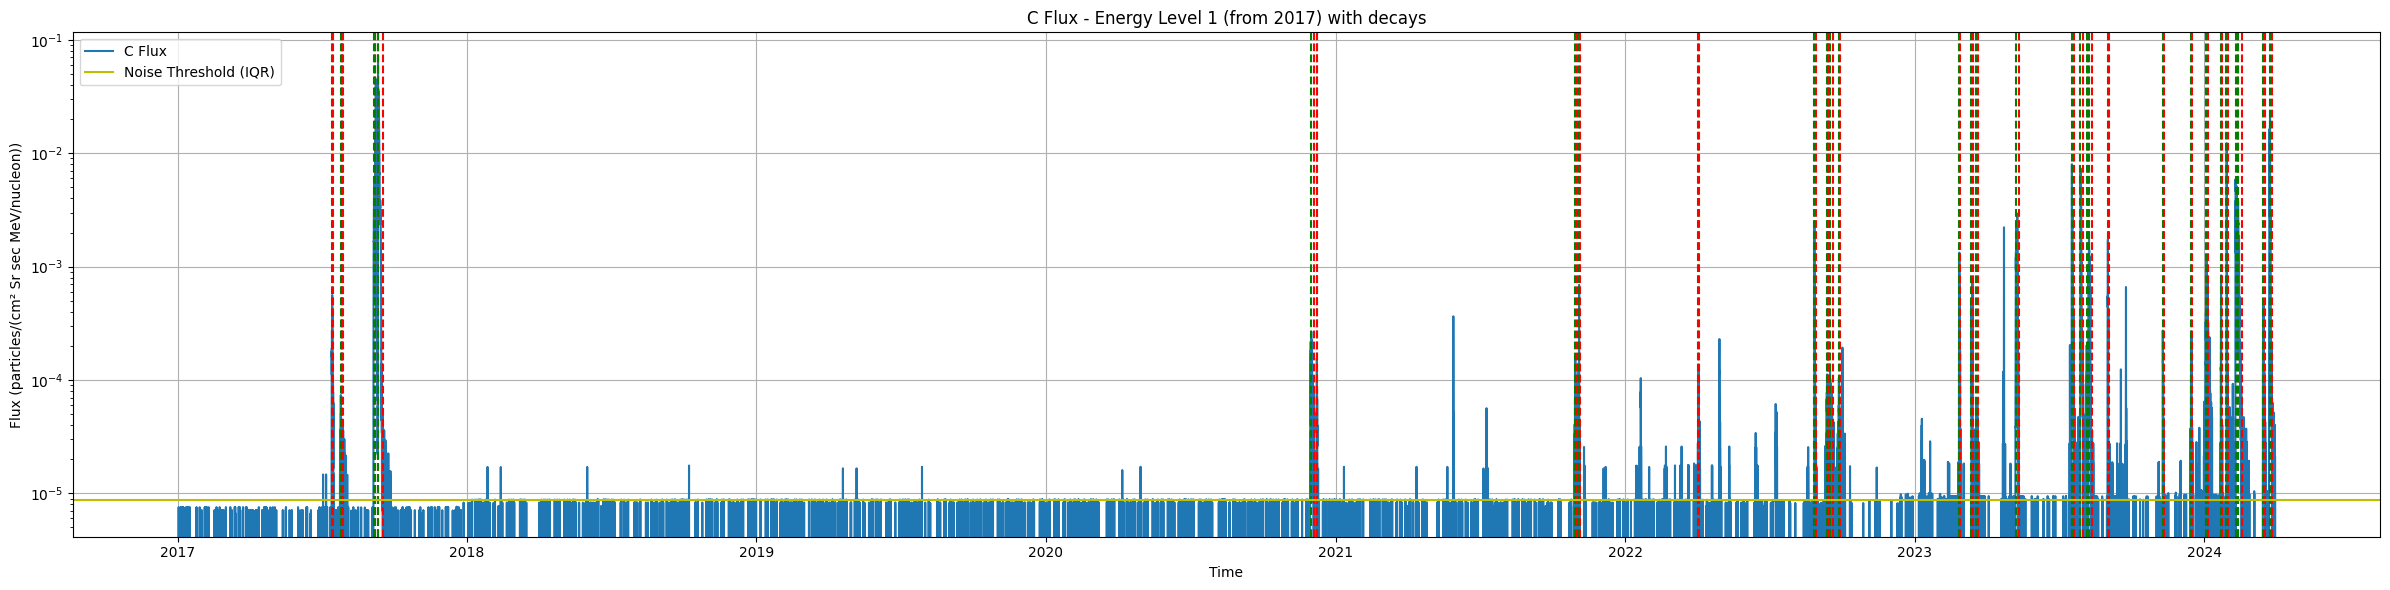

3.7664e-06


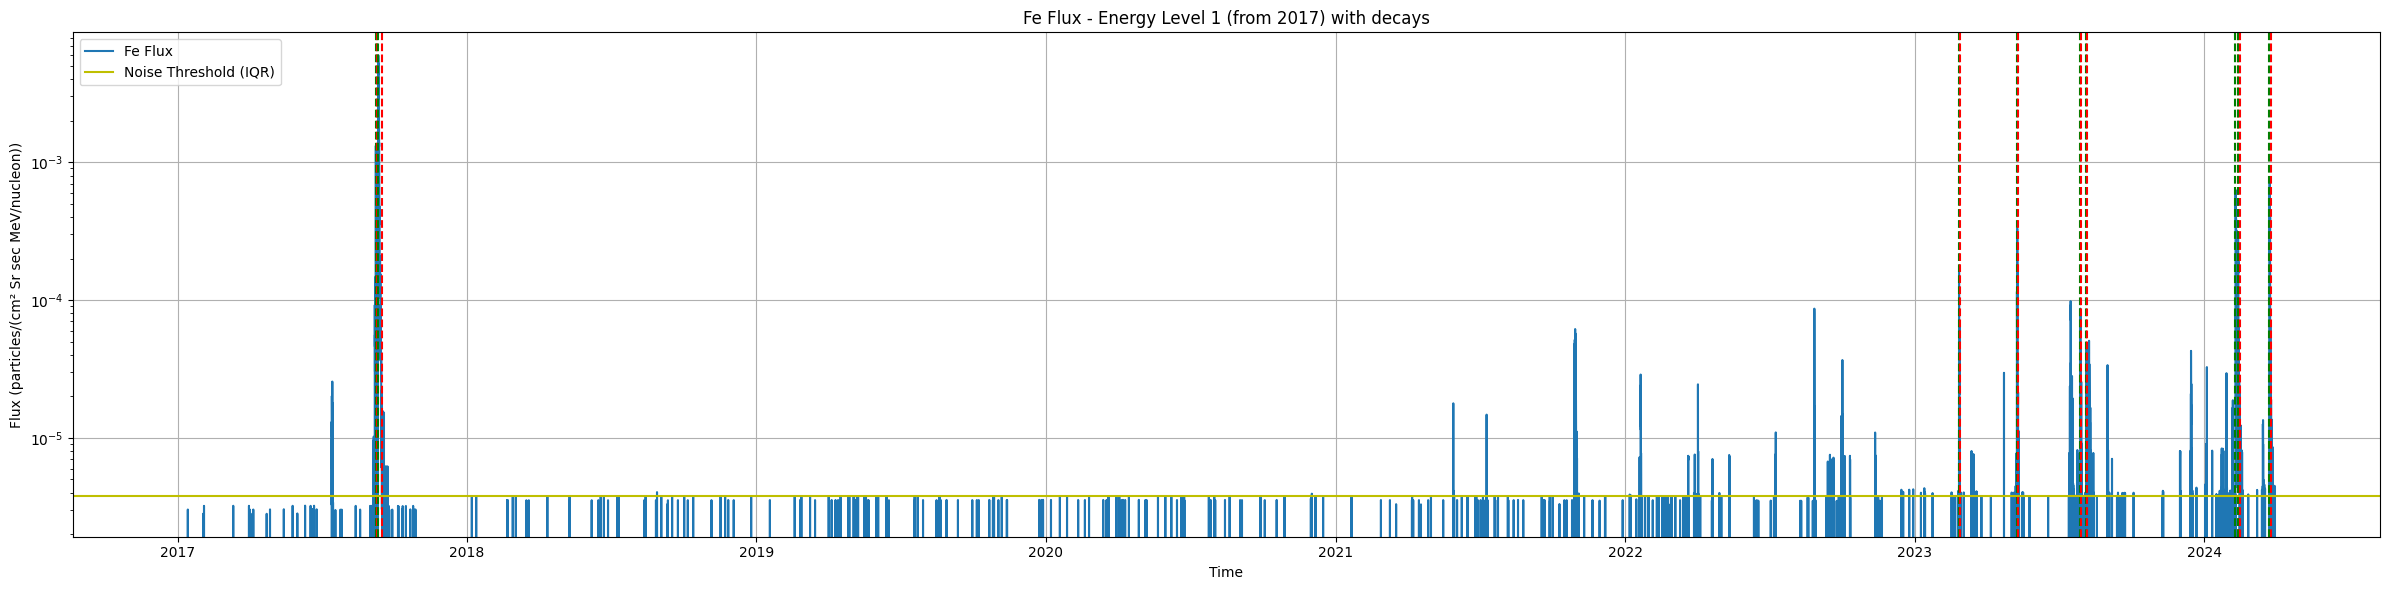

2.6486e-05


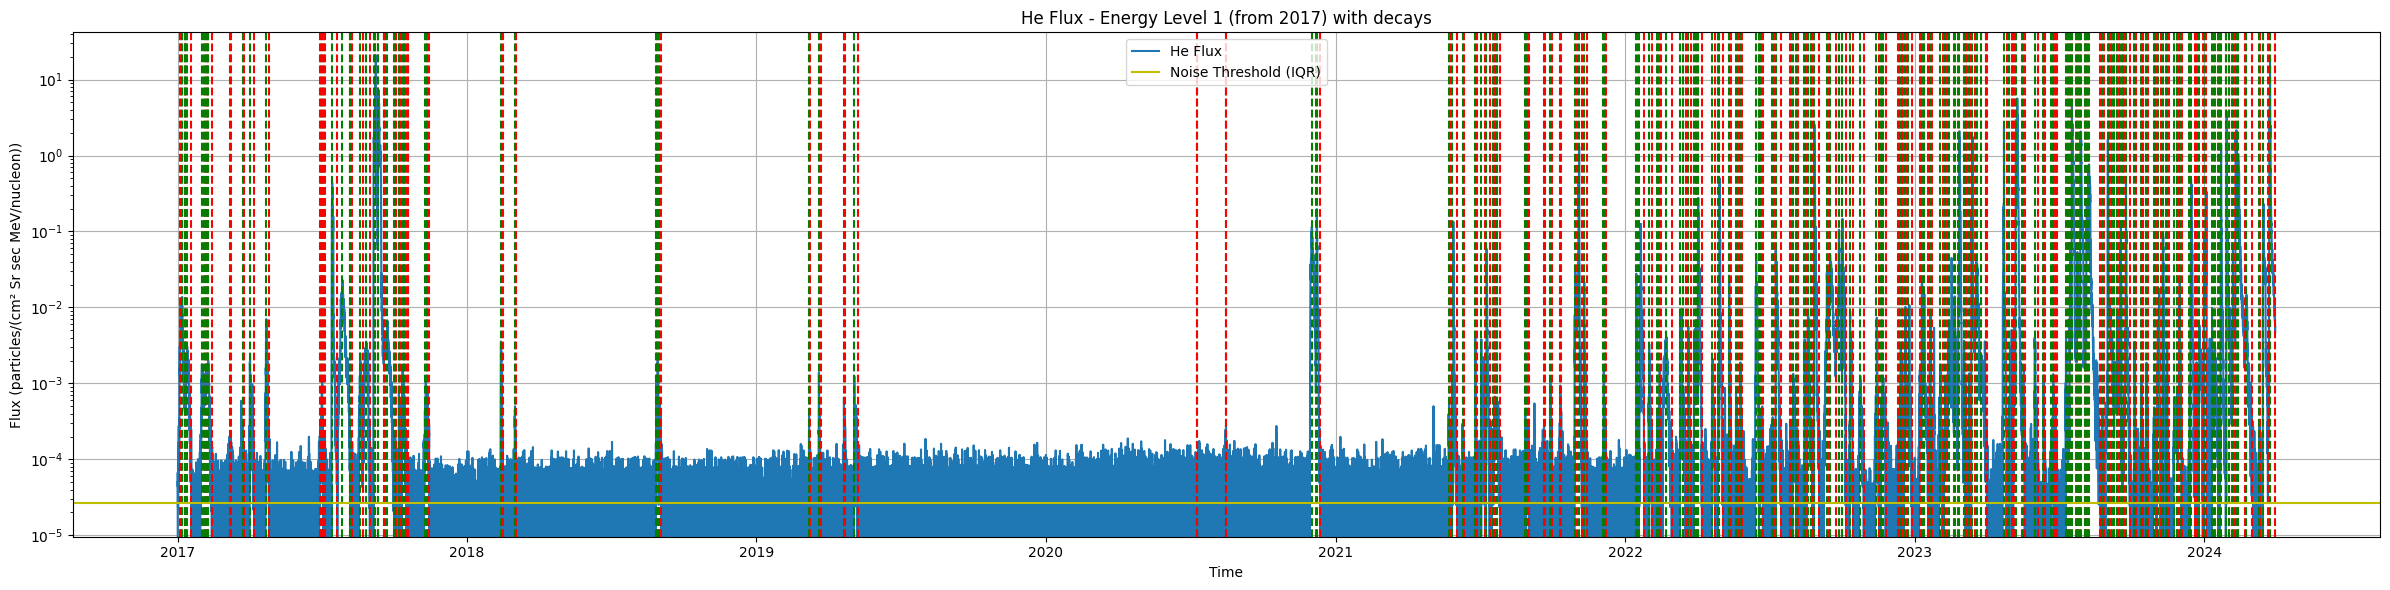

7.4286e-06


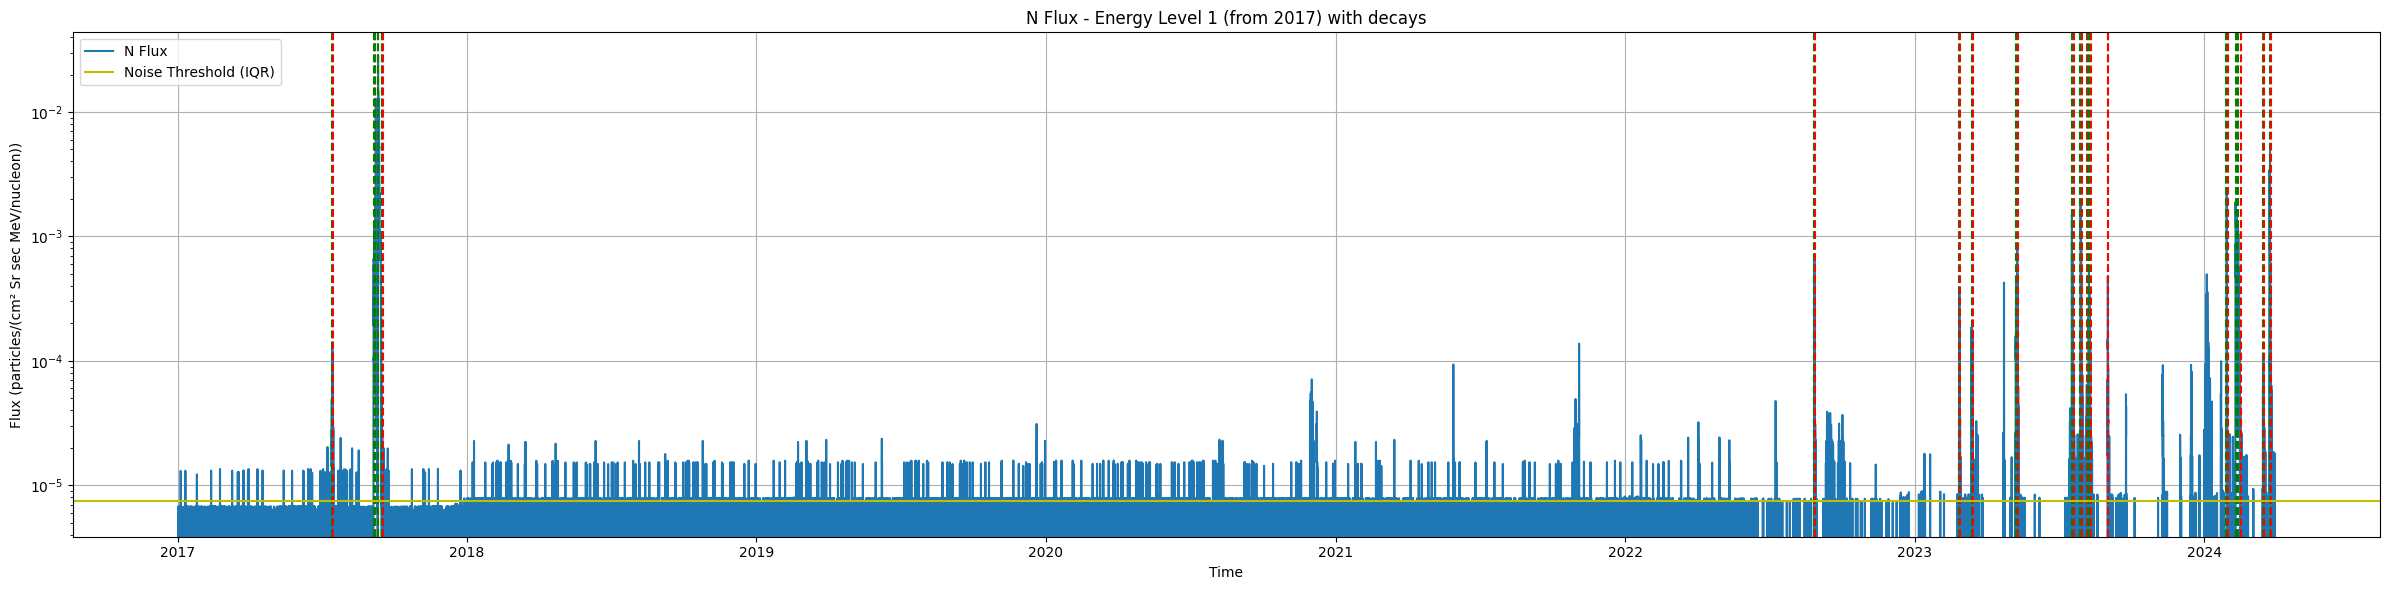

6.7757e-06


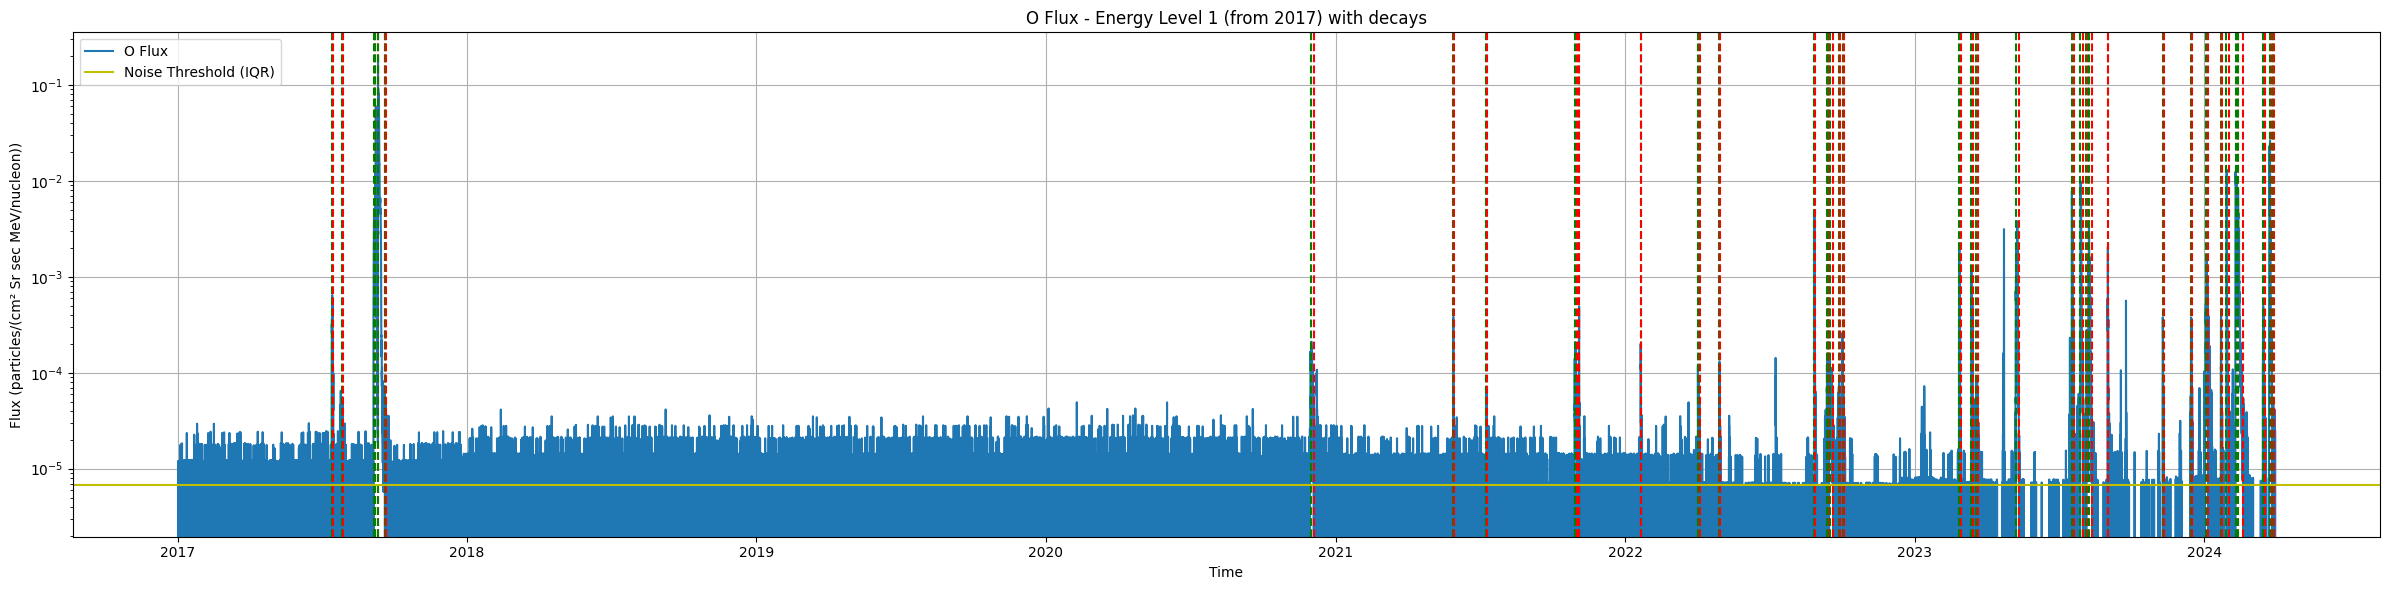

5.0896500000000005e-06


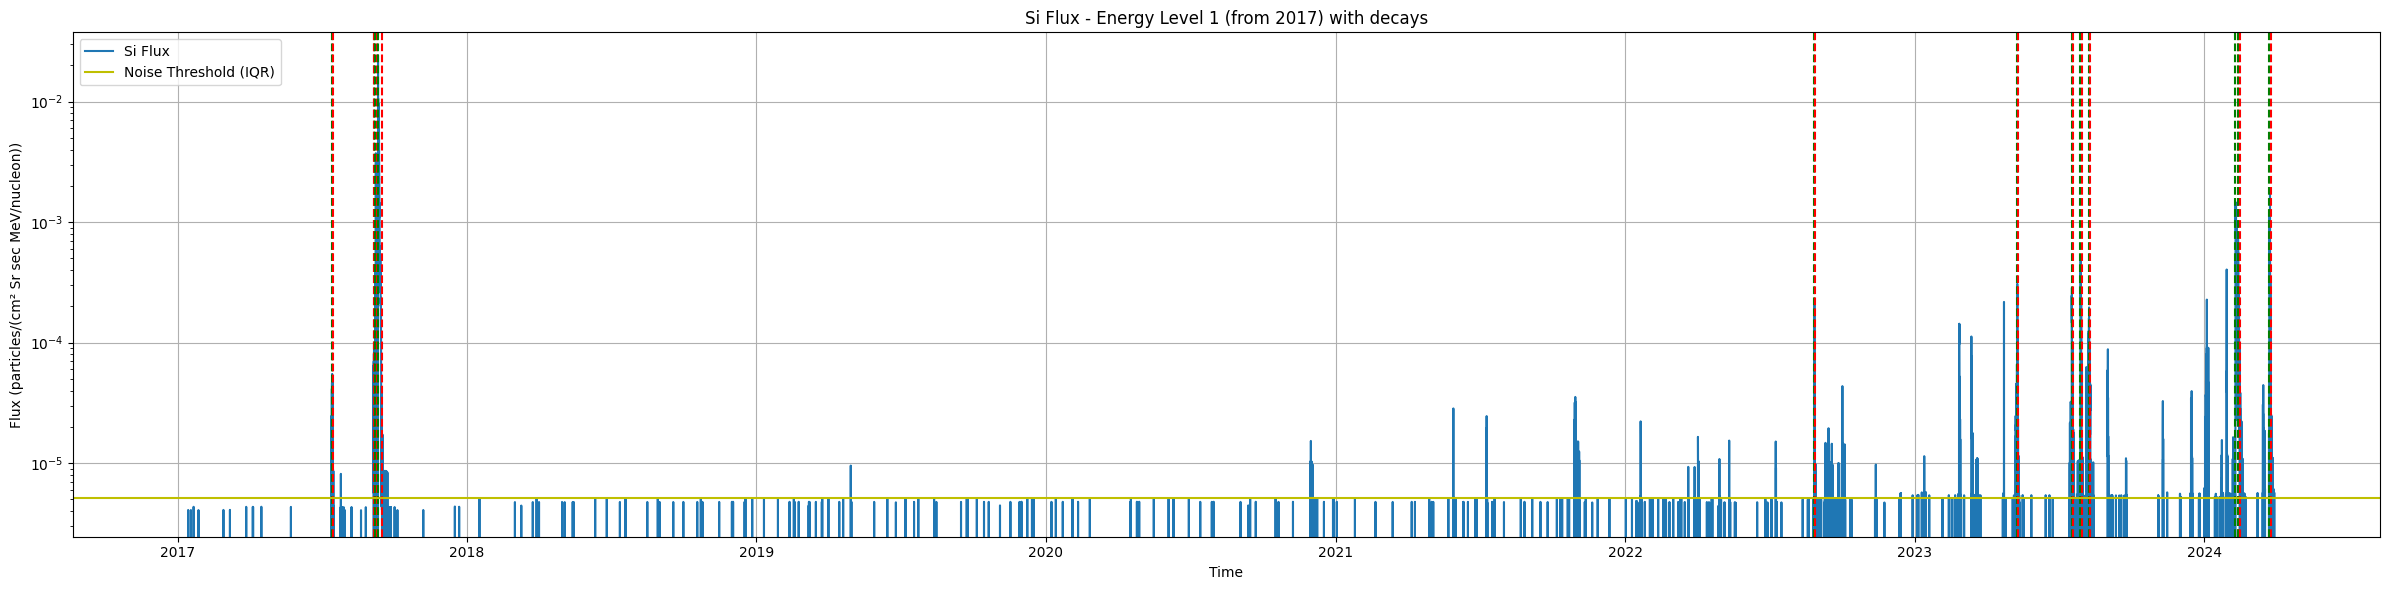

In [138]:
def calculate_noise_threshold_iqr(flux_data):
    """Calculates a noise threshold using q1, ignoring zeros and NaNs."""

    # Remove zeros and NaNs before calculating percentiles and IQR
    valid_flux_data = flux_data[np.logical_and(~np.isnan(flux_data), flux_data != 0)]

    if len(valid_flux_data) == 0:
        return 0 

    Q1 = np.percentile(valid_flux_data, 25)
    return Q1


def plot_element_fluxes_with_decays_and_stats(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time):
    """
    Plots separate graphs for flux data of each element at a specified energy level, 
    starting from a given year and omitting bad data. Includes statistical lines and decay segments.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects for the time axis.
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_level (int): The energy level to plot.
        start_time (datetime): Start time for the analysis window.
        end_time (datetime): End time for the analysis window.
    """
    
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(24, 6)) 

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        # Omit bad data points
        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        # Calculate statistics for the time window
        median_flux = np.median(element_flux)
        # std_flux = np.std(element_flux)
        # noise_cutoff = median_flux + 2 * std_flux  


        plt.plot(element_time, element_flux, label=f'{element_name} Flux')
        plt.yscale('log')

        # Identify exponential decay segments
        decay_segments = identify_exponential_decays(element_flux, element_time, window_size=24, slope_threshold=-0.005)

        for start, end in decay_segments:
            plt.axvline(start, color='g', linestyle='--', label='_nolegend_')
            plt.axvline(end, color='r', linestyle='--', label='_nolegend_')

        noise_threshold = calculate_noise_threshold_iqr(element_flux)
        plt.axhline(noise_threshold, color='y', linestyle='-', label='Noise Threshold (IQR)')
        print(noise_threshold)

        # plt.axhline(median_flux, color='y', linestyle='--', label='Median')
        # print(median_flux)
        # plt.axhline(median_flux + std_flux, color='g', linestyle='-.', label='Median + STD')
        # plt.axhline(noise_cutoff, color='b', linestyle=':', label='Noise Cutoff (2*STD)')

        plt.xlabel('Time')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))') 
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_time.year}) with decays')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Example usage
energy_level_to_plot = 1
start_time = pd.to_datetime('2017-01-01')
end_time = pd.to_datetime('2024-04-01')
plot_element_fluxes_with_decays_and_stats(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, start_time, end_time)


Code below graphs all elements with helium as reference within a certain energy level. For example, if the `energy_level` input of the function is set to 2, then decays are identified based on Helium's flux data over the specified period of time at energy 2, and those windows are applied to the other elements at energy level 2.

Number of helium decay events found: 0


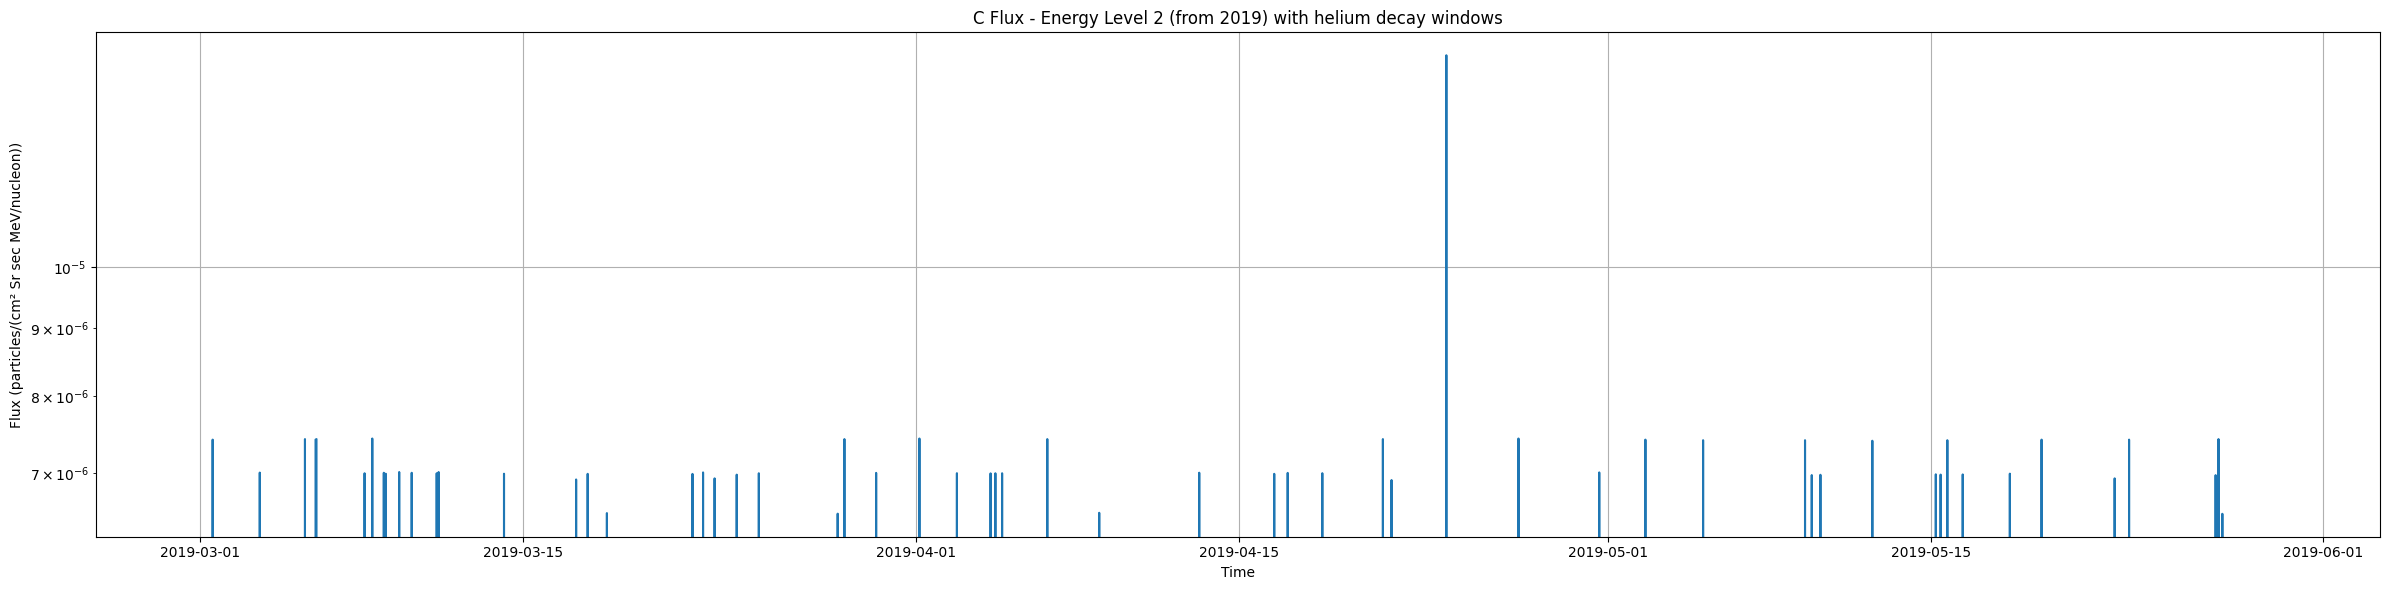

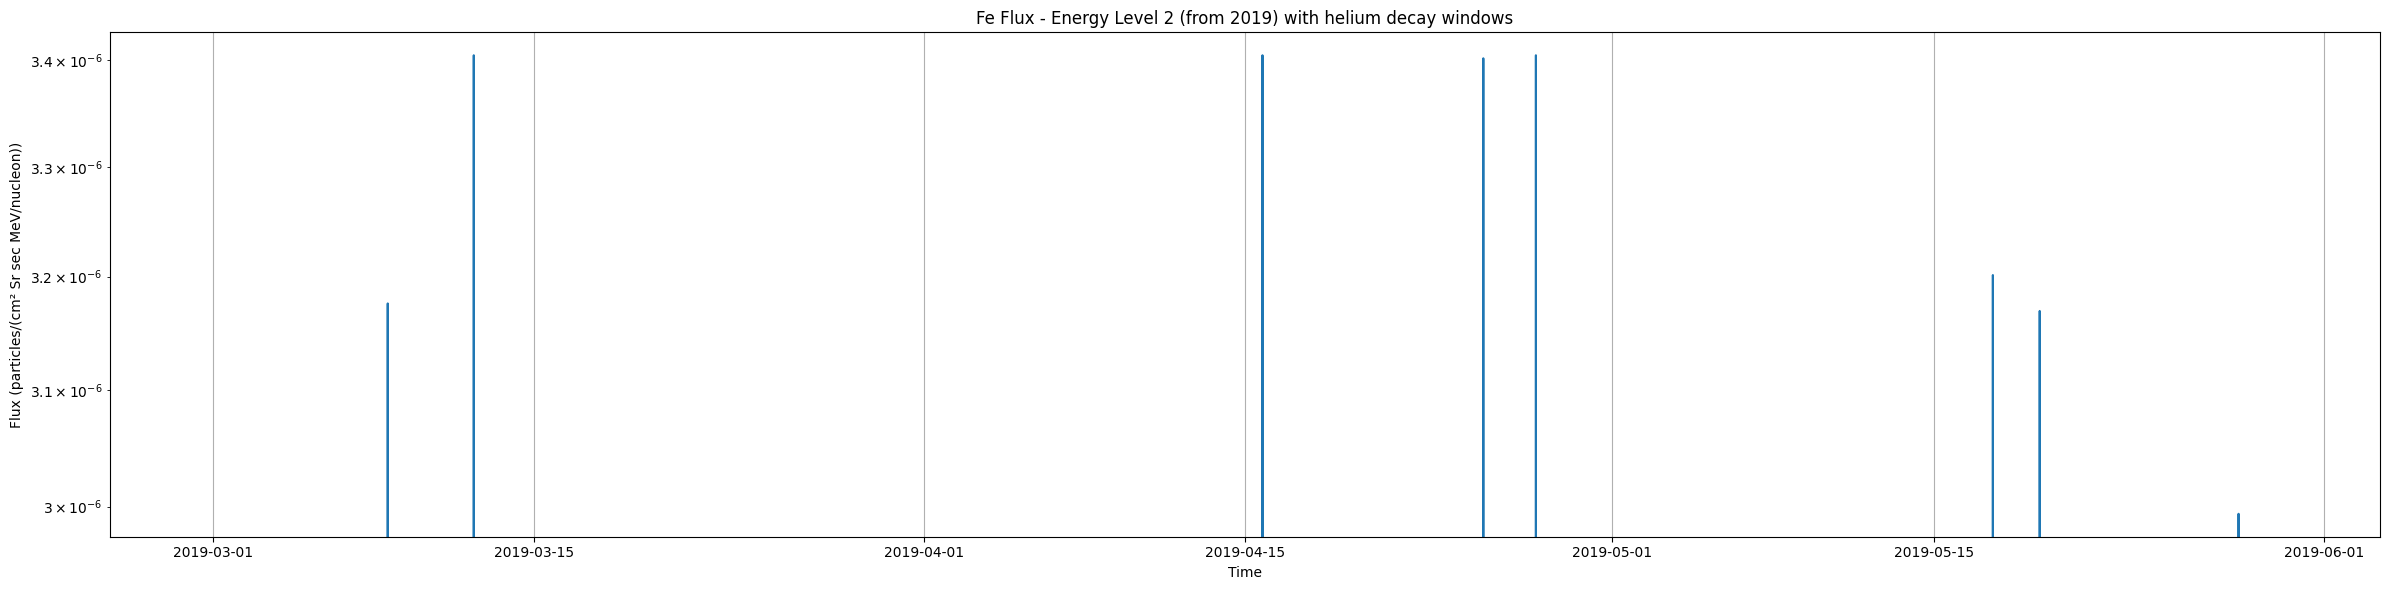

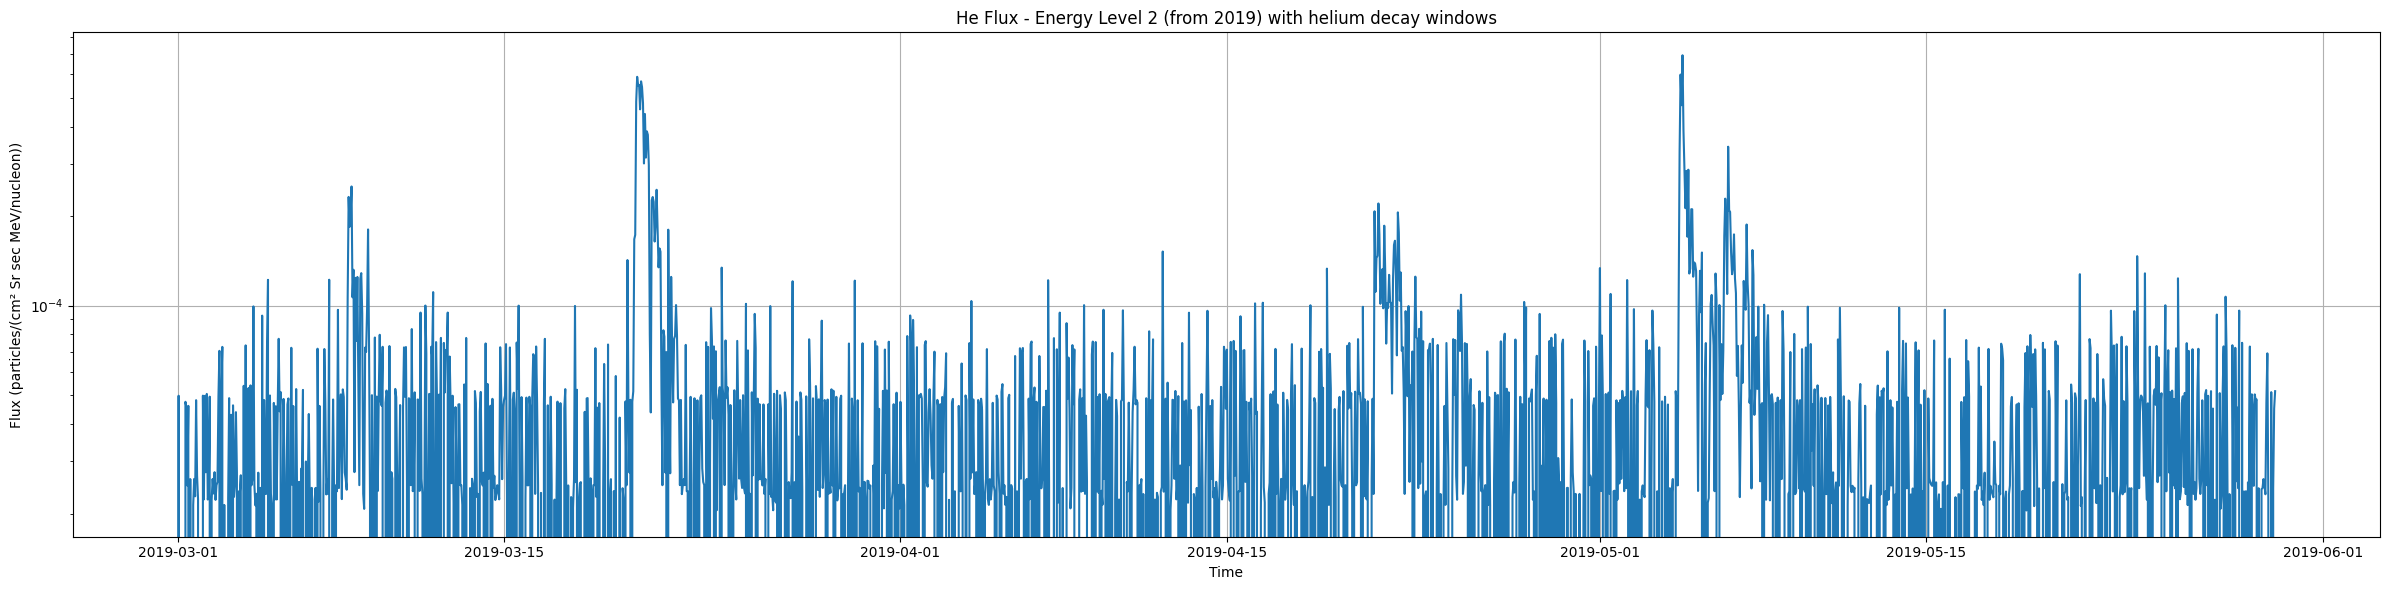

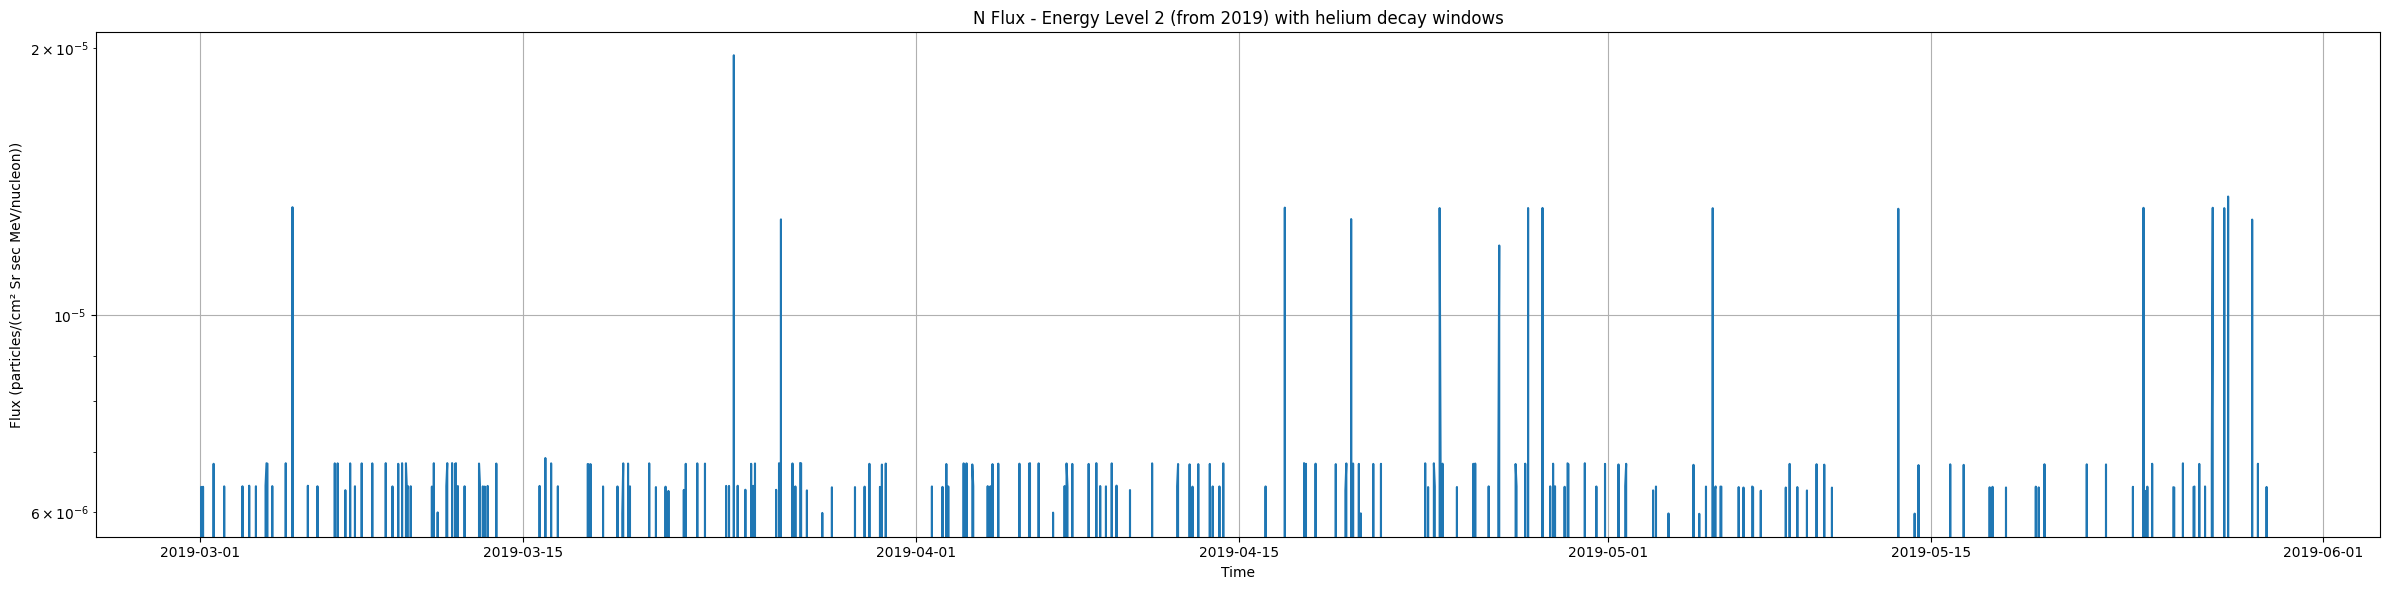

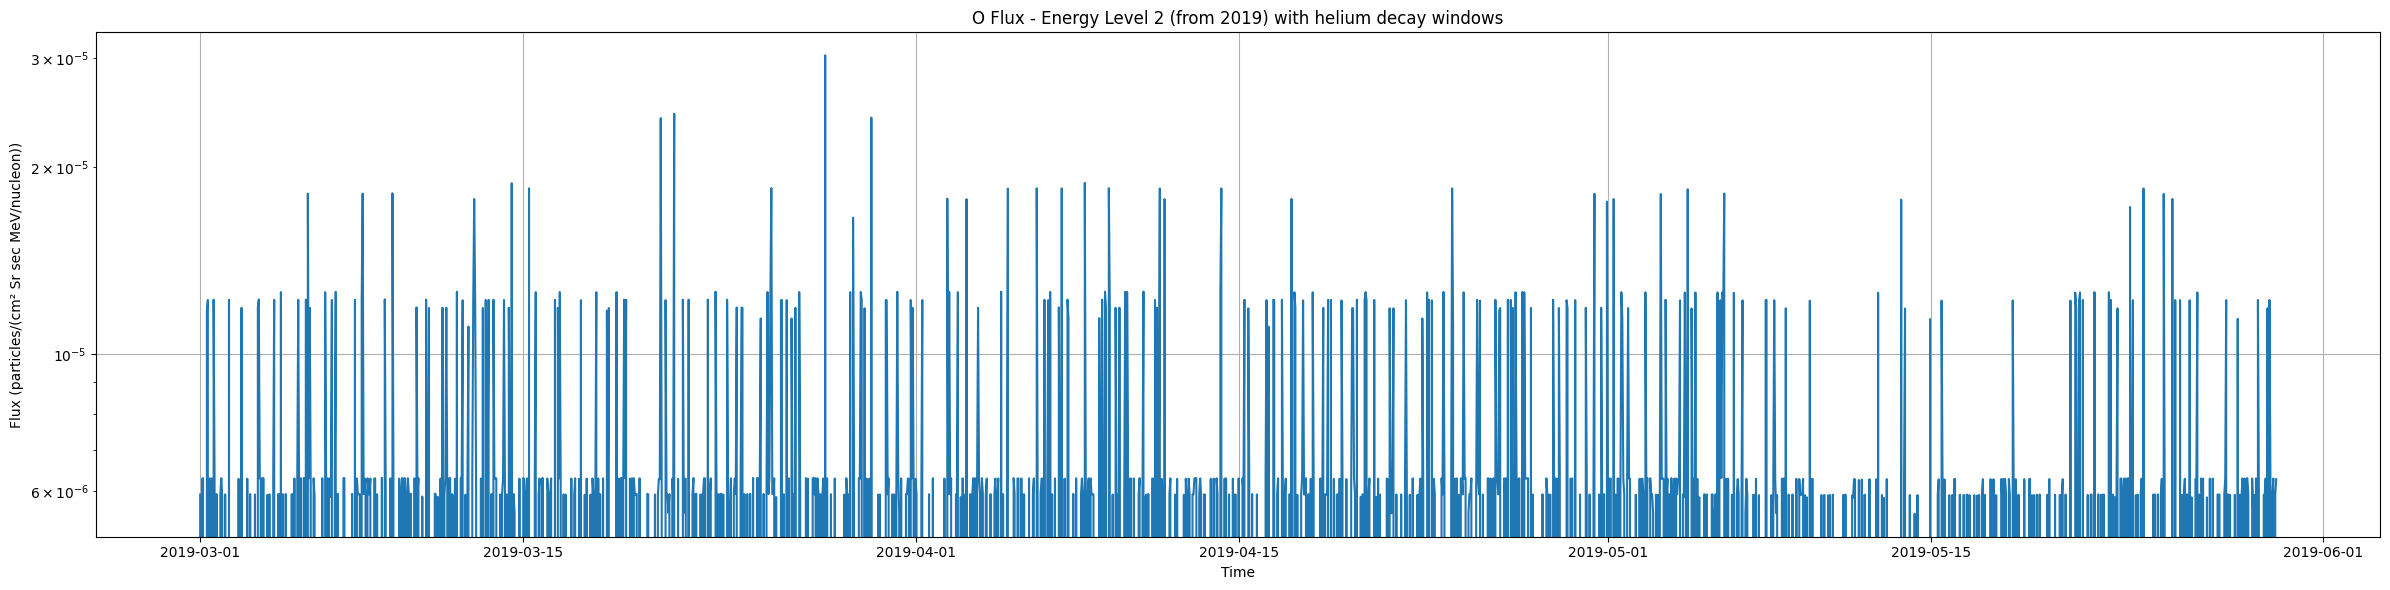

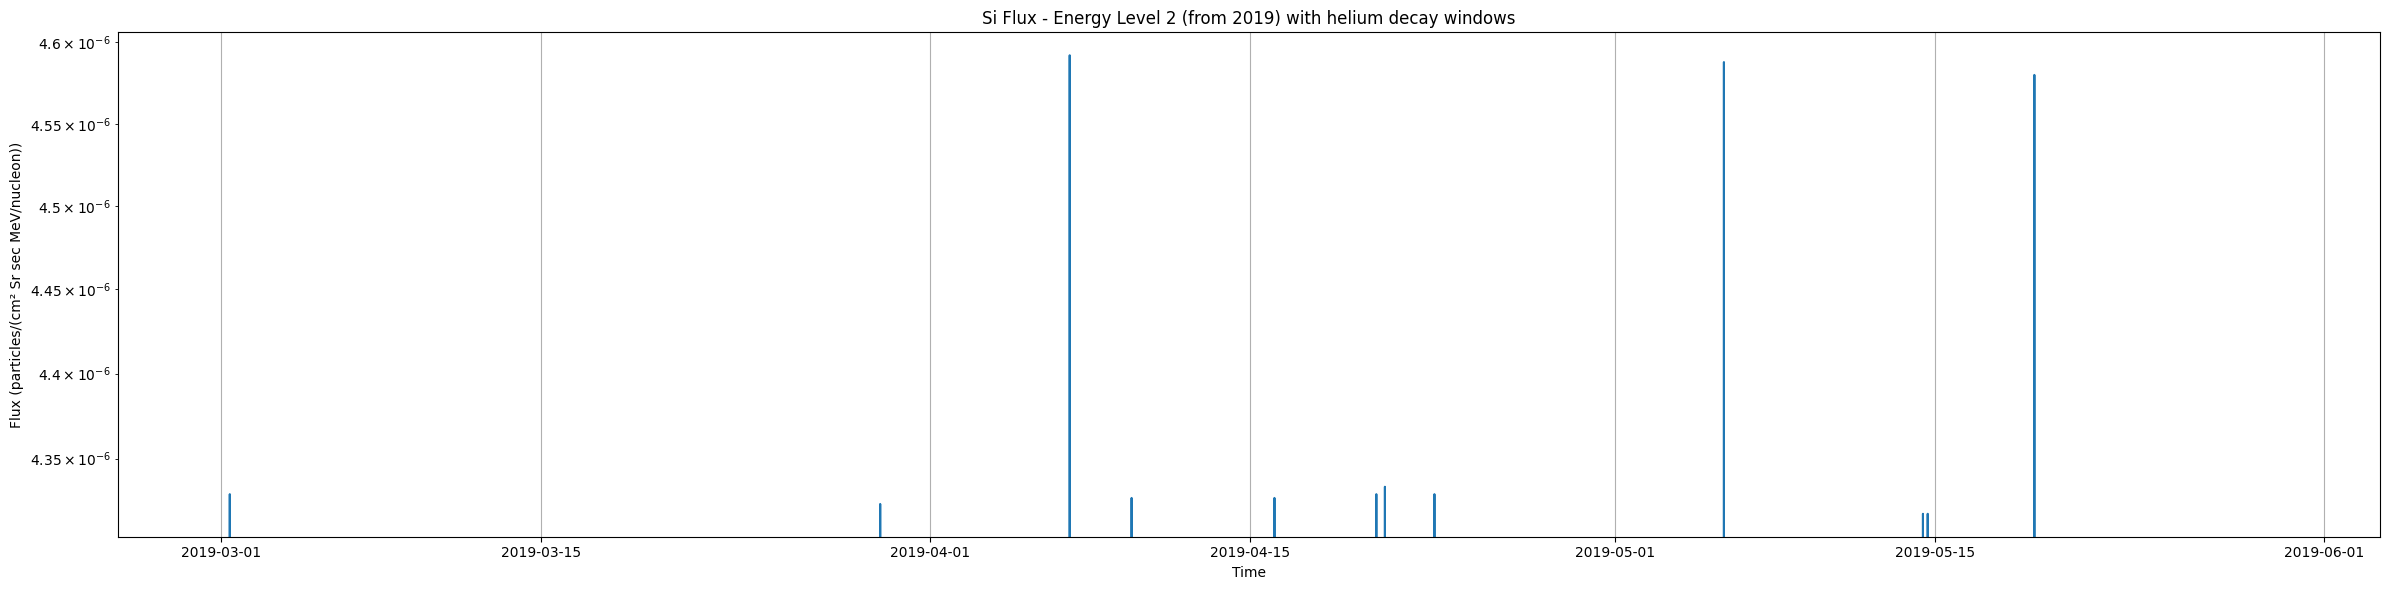

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_fluxes_with_helium_windows(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time):
    
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

    helium_index = element_mapping['He']
    helium_flux = data_3d[energy_level - 1, time_mask, helium_index]

    # Omit bad data points for helium
    valid_data_mask = helium_flux != -999.9
    helium_flux = helium_flux[valid_data_mask]
    helium_time = datetime_values[time_mask][valid_data_mask]

    if len(helium_flux) == 0:
        print("No valid helium data in the specified time range.")
        return
    
    # # Calculate Q1 and filter helium_flux and helium_time 
    # Q1 = np.percentile(helium_flux, 25) 
    # q1_mask = helium_flux >= Q1
    # filtered_helium_flux = helium_flux[q1_mask]
    # filtered_helium_time = helium_time[q1_mask]

    
    # # Calculate statistics for the time window
    # # median_flux = np.median(element_flux)
    # # std_flux = np.std(element_flux)
    # # noise_cutoff = median_flux + 2 * std_flux  

    # # plt.axhline(median_flux, color='r', linestyle='--', label='Median')
    # # plt.axhline(median_flux + std_flux, color='g', linestyle='-.', label='Median + STD')
    # # plt.axhline(noise_cutoff, color='b', linestyle=':', label='Noise Cutoff (2*STD)')

    # Identify exponential decay segments in helium data
    decay_segments = identify_exponential_decays(helium_flux, helium_time, window_size=48, slope_threshold=-0.005)
    #decay_segments = identify_exponential_decays(filtered_helium_flux, filtered_helium_time)
    #print(decay_segments)

    # Print the number of decay events found
    print(f'Number of helium decay events found: {len(decay_segments)}')
    
    # Plot the flux data for each element during the helium decay windows
    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(24, 6))

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        # Omit bad data points
        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        plt.plot(element_time, element_flux, label=f'{element_name} Flux')
        plt.yscale('log')

        for start, end in decay_segments:
            plt.axvline(start, color='g', linestyle='--', label='Decay start')
            plt.axvline(end, color='r', linestyle='--', label='Decay end')

        plt.xlabel('Time')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))')
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_time.year}) with helium decay windows')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example data and parameters (use your actual data here)
energy_level_to_plot = 2
# start_time = pd.to_datetime('2024-03-24')
# end_time = pd.to_datetime('2024-03-30')

# start_time = pd.to_datetime('2018-3-01')
# end_time = pd.to_datetime('2018-3-30')

start_time = pd.to_datetime('2019-3-01')
end_time = pd.to_datetime('2019-5-30')


# Run the plot function with helium windows
plot_fluxes_with_helium_windows(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, start_time, end_time)

Code below uses the `identify_exponential_decays` function defined above to find decay events within the entire data range (2017 to 2024 day 90) based on Helium flux at an energy level defined by `energy_level_to_compute`. The computed event windows are then stored in a Pandas dataframe. Keeps only events that are longer than 48 hours **and** where the helium (reference) flux stays above the threshold for the specified duration, then disregards the rest.

Raising the `he_flux_threshold` will result in only more significant events being kept.

In [165]:
import numpy as np
import pandas as pd

def compute_decay_events_for_all_data(data_3d, datetime_values, element_mapping, energy_level, he_flux_threshold, min_duration_hours):
    """
    Computes decay events for all available data, keeping only events where 
    helium flux stays above the threshold for the specified duration.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects.
        element_mapping (dict): Element name to array index mapping.
        energy_level (int): The energy level to analyze.
        flux_threshold (float): Minimum helium flux threshold.
        min_duration_hours (int): Minimum duration (hours) above threshold.

    Returns:
        pd.DataFrame: DataFrame with decay event details.
    """
    helium_index = element_mapping['He']
    helium_flux = data_3d[energy_level - 1, :, helium_index]

    valid_data_mask = helium_flux != -999.9
    helium_flux = helium_flux[valid_data_mask]
    helium_time = datetime_values[valid_data_mask]

    if len(helium_flux) == 0:
        print("No valid helium data available.")
        return pd.DataFrame()

    decay_segments = identify_exponential_decays(helium_flux, helium_time, window_size=24, slope_threshold=-0.005)
    decay_event_details = []

    for event_number, (start, end) in enumerate(decay_segments):
        # Find indices corresponding to start and end times
        start_index = np.where(helium_time == start)[0][0]
        end_index = np.where(helium_time == end)[0][0]

        # Find periods where helium flux is above the threshold
        above_threshold_mask = helium_flux[start_index:end_index] >= he_flux_threshold
        above_threshold_times = helium_time[start_index:end_index][above_threshold_mask]

        # Calculate the duration of continuous periods above the threshold
        duration_above_threshold = 0
        if len(above_threshold_times) > 1:
            time_differences = np.diff(above_threshold_times)
            # Consider gaps of 1 hour or less as continuous
            continuous_periods = np.where(time_differences <= pd.Timedelta(hours=1))[0]
            if len(continuous_periods) > 0:
                duration_above_threshold = (
                    above_threshold_times[continuous_periods[-1] + 1] - above_threshold_times[0]
                ).total_seconds() / 3600

        # Keep events where the duration above threshold is long enough
        if duration_above_threshold >= min_duration_hours:
            start_year = start.year
            end_year = end.year
            start_frac_day = (
                start.timetuple().tm_yday
                + start.hour / 24
                + start.minute / 1440
                + start.second / 86400
            )
            end_frac_day = (
                end.timetuple().tm_yday
                + end.hour / 24
                + end.minute / 1440
                + end.second / 86400
            )
            start_hour = start.hour + start.minute / 60 + start.second / 3600
            end_hour = end.hour + end.minute / 60 + end.second / 3600

            decay_event_details.append(
                {
                    "Event Number": event_number + 1,
                    "Start Year": start_year,
                    "End Year": end_year,
                    "Start Fractional Day": start_frac_day,
                    "End Fractional Day": end_frac_day,
                    "Start Hour": start_hour,
                    "End Hour": end_hour,
                }
            )

    decay_events_df = pd.DataFrame(decay_event_details)

    return decay_events_df


energy_level_to_compute = 1
he_flux_threshold = 1e-4
min_duration_hours = 48
decay_events_df = compute_decay_events_for_all_data(all_flux_data, datetime_values, element_mapping, energy_level_to_compute, he_flux_threshold, min_duration_hours)

# Fix columns from wrwapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

print(decay_events_df)
decay_events_df.to_csv('decay_events.csv', index=False)

     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour 
0           2         2017       2017           5.999988            10.208322       23.999722   4.999722
1           4         2017       2017          12.958333            18.375000       23.000000   9.000000
2           5         2017       2017          31.874988            34.083333       20.999722   2.000000
3           8         2017       2017          39.625000            43.958322       15.000000  22.999722
4          11         2017       2017          92.041655            97.333322        0.999722   7.999722
..            ...         ...       ...                   ...                 ...         ...        ...
99        182         2024       2024          41.098472            43.466979        2.363333  11.207500
100       183         2024       2024          43.716296            52.982569       17.191111  23.581667
101       184         2024       2024          54.31226

Code below plots all the identified decay events in a grid, each plot showing fluxes of all elements,
    with formatted x-axis ticks showing day of year, and includes 1 day before/after each event
    separated by vertical lines.

Graph of flux events using data from energy level 1 and using data from Helium at energy level 1 for cutoffs


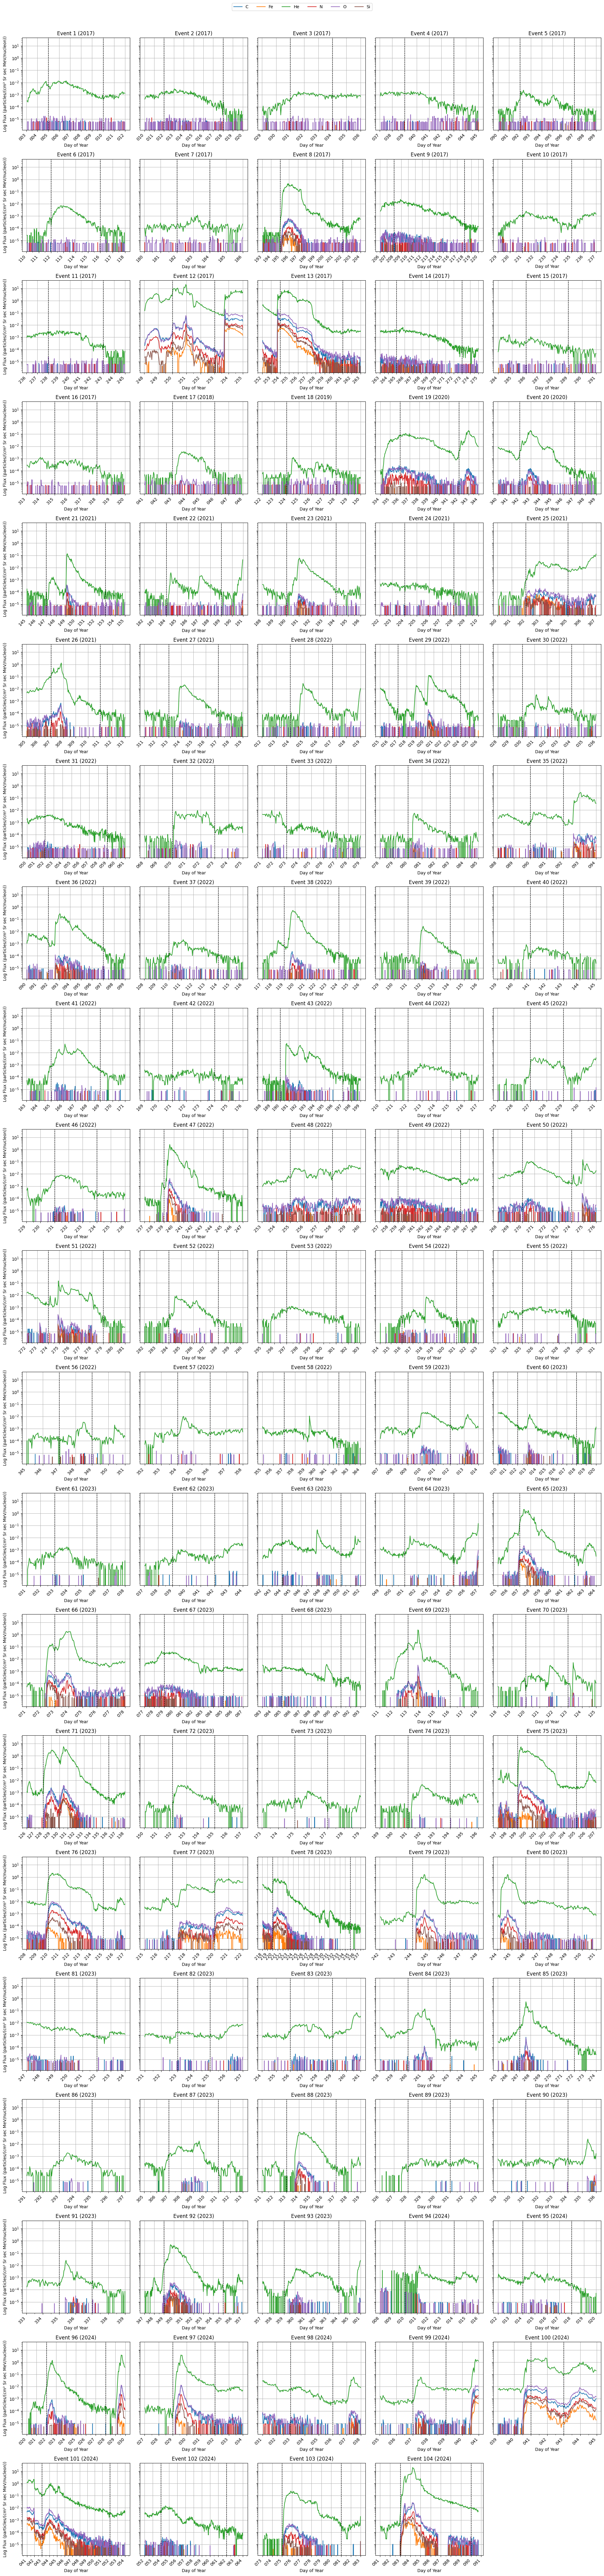

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_all_decay_events(decay_events_df, data_3d, datetime_values, element_mapping, energy_level, extend_days):
    """
    Args:
        decay_events_df (pd.DataFrame): DataFrame containing decay event details.
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects for the time axis.
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_level (int): The energy level to analyze.
        extend_days (int): Number of days to extend the time range before and after the event.
    """

    num_events = len(decay_events_df)
    if num_events == 0:
        print("No decay events found to plot.")
        return

    num_cols = 5
    num_rows = int(np.ceil(num_events / num_cols))

    #add key at top
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), sharey=True)
    fig.subplots_adjust(hspace=0.5, top=0.95)  

    lines = []
    labels = []

    for i, row in decay_events_df.iterrows():
        ax = axes[i // num_cols, i % num_cols]

        start_time = pd.to_datetime(
            f"{int(row['Start Year'])}-{row['Start Fractional Day']:.5f}", format="%Y-%j.%f"
        )
        end_time = pd.to_datetime(
            f"{int(row['End Year'])}-{row['End Fractional Day']:.5f}", format="%Y-%j.%f"
        )

        # Extend time range by extend_days before and after
        extended_start_time = start_time - pd.Timedelta(days=extend_days)
        extended_end_time = end_time + pd.Timedelta(days=extend_days)

        time_mask = (datetime_values >= extended_start_time) & (
            datetime_values <= extended_end_time
        )

        for element_name, element_index in element_mapping.items():
            element_flux = data_3d[energy_level - 1, time_mask, element_index]

            valid_data_mask = element_flux != -999.9
            element_flux = element_flux[valid_data_mask]
            element_time = datetime_values[time_mask][valid_data_mask]

            line, = ax.plot(element_time, element_flux, label=f"{element_name}")
            if element_name not in labels:
                lines.append(line)
                labels.append(element_name)

        ax.set_yscale("log")
        ax.set_xlabel("Day of Year")
        if i % num_cols == 0:
            ax.set_ylabel("Log Flux (particles/(cm² Sr sec MeV/nucleon))")
        ax.set_title(f"Event {i+1} ({start_time.year})")
        ax.grid(True)

        # Set major ticks to daily
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%j"))

        # Set minor ticks to half-daily
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=12))

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        # Lines to separate out extra days added before and after each event on plot
        ax.axvline(start_time, color="black", linestyle="--", linewidth=1)
        ax.axvline(end_time, color="black", linestyle="--", linewidth=1)

    # Hide any unused subplots in the grid, not really needed but its nice to have
    for j in range(i+1, num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')


    #add key at top
    fig.legend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.01))

    plt.tight_layout()
    plt.show()

energy_level_to_plot = 1
extend_days = 2  # Adjust the number of days to extend before and after
print(f"Graph of flux events using data from energy level {energy_level_to_plot} and using data from Helium at energy level {energy_level_to_compute} for cutoffs")
plot_all_decay_events(decay_events_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days)



     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour 
0           2         2017       2017           5.999988            10.208322       23.999722   4.999722
1           4         2017       2017          12.958333            18.375000       23.000000   9.000000
2           5         2017       2017          31.874988            34.083333       20.999722   2.000000
3           8         2017       2017          39.625000            43.958322       15.000000  22.999722
4          11         2017       2017          92.041655            97.333322        0.999722   7.999722
..            ...         ...       ...                   ...                 ...         ...        ...
99        182         2024       2024          41.098472            43.466979        2.363333  11.207500
100       183         2024       2024          43.716296            52.982569       17.191111  23.581667
101       184         2024       2024          54.31226

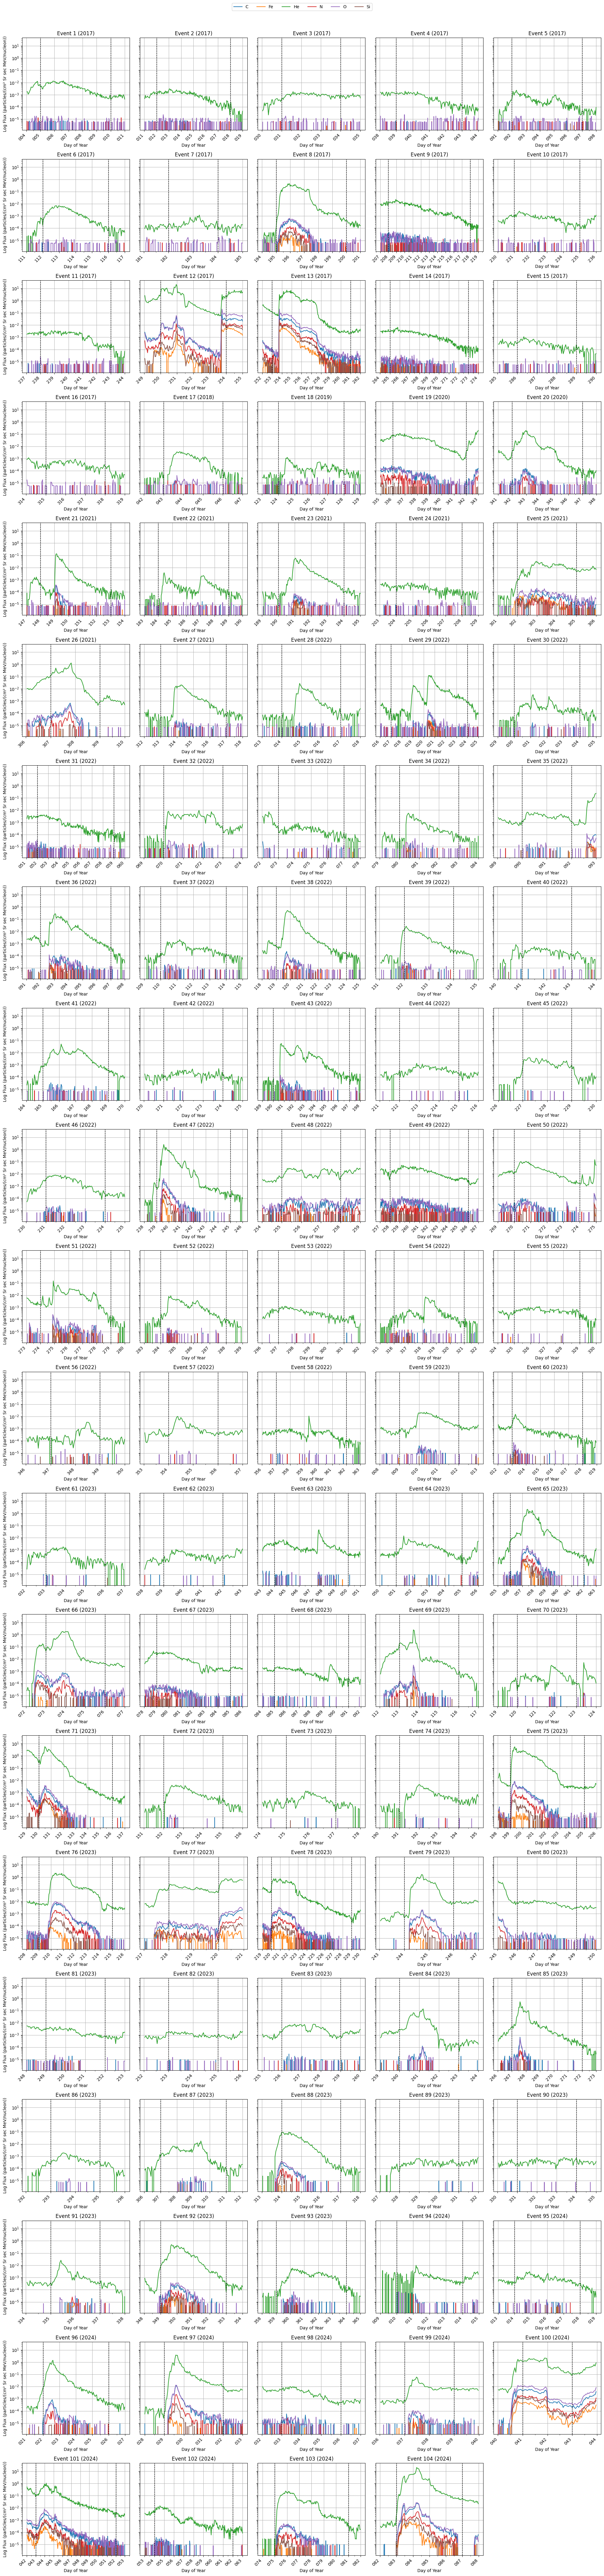

In [181]:
import pandas as pd

def clean_events(csv_path, manual_trim_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # Read the manual trim instructions
    with open(manual_trim_path, 'r') as file:
        manual_trim_lines = file.readlines()

    # Initialize an empty list to store the cleaned events
    cleaned_events = []

    # Process each line in the manual trim instructions
    for line in manual_trim_lines:
        parts = line.strip().split(',')
        event_index = int(parts[0]) - 1  # Adjust for zero-based index
        
        if len(parts) > 1:
            action = parts[1].strip()
            amount = float(parts[2].strip())
            
            # Extract the event from the DataFrame
            event = df.iloc[event_index].copy()
            
            # Process the event based on the action
            if action == 'shorten back':
                event['End Fractional Day'] -= amount
            elif action == 'shorten front':
                event['Start Fractional Day'] += amount
            elif action == 'lengthen back':
                event['End Fractional Day'] += amount
            elif action == 'lengthen front':
                event['Start Fractional Day'] -= amount
        
        else:
            # If no action specified, just take the event as is
            event = df.iloc[event_index].copy()
        
        # Append the processed event to the list
        cleaned_events.append(event)
    
    # Create a new DataFrame from the cleaned events
    cleaned_df = pd.DataFrame(cleaned_events)

    return cleaned_df


decay_events_file = 'decay_events.csv'
manual_trim_file = 'manual_trim.txt'
cleaned_decay_events_df = clean_events(decay_events_file, manual_trim_file)
print(cleaned_decay_events_df)

energy_level_to_plot = 1
extend_days = 1
print(f"Graph of cleaned flux events using data from energy level {energy_level_to_plot} and using data from Helium at energy level {energy_level_to_compute} for cutoffs")
plot_all_decay_events(cleaned_decay_events_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days)